In [1]:
from typing import TypedDict, Annotated, List, Literal, Sequence
import operator
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, PromptTemplate, BasePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langsmith import traceable

from langchain.agents import AgentExecutor
from langchain.agents import create_tool_calling_agent
from langchain.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

# Initialize LLM
api_key = os.getenv("GOOGLE_API_KEY")
openweather_secret = os.getenv("OPENWEATHERMAP_API_KEY")

os.environ["OPENWEATHERMAP_API_KEY"] = openweather_secret
os.environ["GOOGLE_API_KEY"] = api_key

weather = OpenWeatherMapAPIWrapper()

llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [3]:
class State(TypedDict):
    input: str
    user_feedback: str

config = {"configurable": {"thread_id": "1"}}

memory = MemorySaver()


## LangGraph Tool + Memory

In [4]:
# Tool setup
search = GoogleSerperAPIWrapper()
search_tool = Tool(
    name="google_search",
    func=search.run,
    description="Use this tool to search Google using Serper API.",
    return_direct=True
)

tools = [search_tool]

# LLM binding
llm_with_tools = llm_gemini.bind_tools(tools)

# State type
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Graph definition
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.set_entry_point("chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(checkpointer=memory)



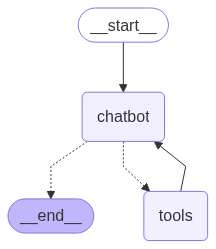

In [5]:
graph

In [6]:
user_input = "Hi there! My name is Quan."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Quan.
================================== Ai Message ==================================

Hi Quan, nice to meet you! How can I help you today?


In [10]:
# follow up question
user_input = "Remember my name?"


events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is still Quan.


In [26]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am a large language model, I don't have memory of past conversations. I don't remember your name.


## Human In The Loop 

In [4]:
def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)


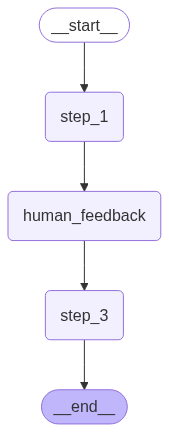

In [5]:
graph

In [6]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', resumable=True, ns=['human_feedback:19fa56bf-5d50-1f8a-2f72-88dc061188e6']),)}




In [9]:
thread = {"configurable": {"thread_id": "1"}}

graph.get_state(thread).values

{'input': 'hello world'}

In [10]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")
    

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




In [ ]:
from langgraph.graph import MessagesState, START
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel

# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

search = GoogleSerperAPIWrapper()
weather = OpenWeatherMapAPIWrapper()

@tool
def search_tool(query: str) -> str:
    """Use this tool to search for weather information using the Serper API."""
    try:
        # Extract city name
        res = llm_gemini.invoke(f"""
        You are given one question and you have to extract the city name from it.
        Only reply the city name if it exists or 'no_response' if there is no city name.
        Question: {query}
        """)
        
        city = res.content.strip()
        if city == "no_response":
            return "No city name found in the query."
        
        # Search for weather using OpenWeatherMapAPIWrapper
        response = weather.run(city)

        # Search for weather using GoogleSerperAPIWrapper
        # search_query = f"weather in {city}"
        # result = search.run(search_query)

        return f"Weather information for {city}: {response}" if response else f"No weather information found for {city}."
    
    except Exception as e:
        return f"Error processing query: {str(e)}"


tools = [search_tool]
tool_node = ToolNode(tools)

model = model.bind_tools(tools + [AskHuman])

# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    location = interrupt(ask.question)
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]

    return {"messages": tool_message}

# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"

In [ ]:
# Build the graph
workflow = StateGraph(MessagesState)

# Define nodes and edges
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    path_map=["ask_human", "action", END],
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

memory = MemorySaver()

# compile
app = workflow.compile(checkpointer=memory)

app

In [11]:
app.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Ask the user where they are, then look up the weather there', additional_kwargs={}, response_metadata={}, id='daaa2924-5bd3-4fa8-84c4-363fbda2a8d5'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'AskHuman', 'arguments': '{"question": "Where are you located?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--d6bb562d-3ecf-432e-8111-4b958f0ea737-0', tool_calls=[{'name': 'AskHuman', 'args': {'question': 'Where are you located?'}, 'id': 'b7950c60-3b87-41d3-8e40-e12afc7b73dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 45, 'output_tokens': 8, 'total_tokens': 53, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='Im currently in Viet Nam right now', id='fe469500-ed3a-459a-ae79-19b3430ea307', tool_call_id='b7950c60-3b87-41d3-8e40-e12afc7b73dd'), AIMessage(content='

In [6]:
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": ["Ask the user where they are, then look up the weather there"]
    },
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (b7950c60-3b87-41d3-8e40-e12afc7b73dd)
 Call ID: b7950c60-3b87-41d3-8e40-e12afc7b73dd
  Args:
    question: Where are you located?


In [7]:
for event in app.stream(
    Command(resume="Im currently in Viet Nam right now"),
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (b7950c60-3b87-41d3-8e40-e12afc7b73dd)
 Call ID: b7950c60-3b87-41d3-8e40-e12afc7b73dd
  Args:
    question: Where are you located?
================================= Tool Message =================================

Im currently in Viet Nam right now
================================== Ai Message ==================================
Tool Calls:
  search_tool (e5afdb80-eb2e-4550-ab83-484393dba697)
 Call ID: e5afdb80-eb2e-4550-ab83-484393dba697
  Args:
    query: weather in Viet Nam
================================= Tool Message =================================
Name: search_tool

No city name found in the query.
================================== Ai Message ==================================

My apologies, I need a city to look up the weather. Can you give me a city in Viet Nam?
